## Import Libraries

In [ ]:
from collections import Counter
from datetime import datetime as dt
from imblearn import under_sampling, over_sampling
from matplotlib import rcParams
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.manifold import MDS
from sklearn.metrics import r2_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import json 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sn
import tensorflow as tf
import torch
import torch.nn as nn
random_seed = 42

## Import Data via API

In [ ]:
# Read data from NASA API
r = requests.get('https://ssd-api.jpl.nasa.gov/cad.api?date-min=1900-01-01&date-max=2100-01-01&dist-max=0.2&diameter=true')
x = r.json()
df = pd.json_normalize(x, record_path =['data'])

## Clean dataset

#### Features returned by the API

-	des - primary designation of the asteroid or comet (e.g., 443, 2000 SG344)
-	orbit_id - orbit ID
-	jd - time of close-approach (JD Ephemeris Time, TDB)
-	cd - time of close-approach (formatted calendar date/time, TDB)
-	dist - nominal approach distance (au)
-	dist_min - minimum (3-sigma) approach distance (au)
-	dist_max - maximum (3-sigma) approach distance (au)
-	v_rel - velocity relative to the approach body at close approach (km/s)
-	v_inf - velocity relative to a massless body (km/s)
-	t_sigma_f - 3-sigma uncertainty in the time of close-approach (formatted in days, hours, and minutes; days are not included if zero; example “13:02” is 13 hours 2 minutes; example “2_09:08” is 2 days 9 hours 8 minutes)
-	body - name of the close-approach body (e.g., Earth)
  - only output if the body query parameters is set to ALL
-	h - absolute magnitude H (mag)
-	diameter - diameter of the body (km)
  -	optional - only output if requested with the diameter query parameter
  -	null if not known
-	diameter_sigma - 1-sigma uncertainty in the diameter of the body (km)
  -	optional - only output if requested with the diameter query parameter
  -	null if not known
-	fullname - formatted full-name/designation of the asteroid or comet
  -	optional - only output if requested with the fullname query parameter
  -	formatted with leading spaces for column alignment in monospaced font tables

In [ ]:
# Reorganize column names
col_names = ["des","orbit_id","jd","cd","dist","dist_min","dist_max","v_rel","v_inf","t_sigma_f", "h","diameter","diameter_sigma"]
df = df.set_axis(col_names, axis=1)
df.drop(['orbit_id'], axis = 1, inplace=True)
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)
df.head()

,des,jd,cd,dist,dist_min,dist_max,v_rel,v_inf,t_sigma_f,h,diameter,diameter_sigma
0,4660,2415049.256344873,1900-Jan-29 18:09,0.0207980717893431,0.020767017204674,0.0208291286549887,5.54486978985514,5.52171687951586,00:35,18.67,0.33,0.05
1,511684,2415060.431971336,1900-Feb-09 22:22,0.0896394434006175,0.0883682229712889,0.0909118841949699,15.8098733510006,15.8079931224619,00:39,20.81,0.315,0.065
2,311554,2415070.836772925,1900-Feb-20 08:05,0.178568899502934,0.178558048607585,0.178579750570992,19.600335110188,19.5995738178264,< 00:01,18.73,0.382,0.015
3,388189,2415071.791423170,1900-Feb-21 07:00,0.171344334277094,0.171341610901274,0.171347059305223,14.5360249625754,14.5349551371129,< 00:01,20.42,0.315,0.014
4,504800,2415077.689040186,1900-Feb-27 04:32,0.142765329998076,0.14274423452057,0.142786426070399,16.5578156272785,16.5566884263344,00:02,21.9,0.380,0.003


In [ ]:
# function to convert t_sigma_f in minutes 
def t_sigma_to_minutes(x):
  ''' converts time in format days, hours, and minutes into minutes
  days are not included if zero; example “13:02” is 13 hours 2 minutes; example “2_09:08” is 2 days 9 hours 8 minutes
  '''
  if x[0]=='<':
    return 0.5 # convert < 00:01 into 0.5 minutes
  elif x[1]=='_':
    return int(x[0])*1440 + int(x[2:4])*60 + int(x[5:])
  else:
    return int(x[:2])*60 + int(x[3:])

In [ ]:
#Convert columns from Python Objects to float
cols_to_float = ['dist', 'dist_min', 'dist_max', 'v_rel', 'v_inf', 'h', 'diameter', 'diameter_sigma']
df[cols_to_float] = df[cols_to_float].astype(float)

#Convert "cd" column to datetime and add an ordinal date column for ML algorithms
df['cd'] = pd.to_datetime(df['cd'])
df['ordinal_dates'] = df.cd.apply(lambda x: x.toordinal())

#Convert "t_sigma_f" into minutes using function t_sigma_to_minutes
df['t_sigma_f_min'] = df.t_sigma_f.apply(t_sigma_to_minutes)

#Add binary labels for PHA designation
df['PHA'] = np.where((df['dist'] <= 0.05) & (df['h'] <= 22.0), 1, 0)

df.head()

,des,jd,cd,dist,dist_min,dist_max,v_rel,v_inf,t_sigma_f,h,diameter,diameter_sigma,ordinal_dates,t_sigma_f_min,PHA
0,4660,2415049.256344873,1900-01-29 18:09:00,0.020798,0.020767,0.020829,5.544870,5.521717,00:35,18.67,0.330,0.050,693624,35.0,1
1,511684,2415060.431971336,1900-02-09 22:22:00,0.089639,0.088368,0.090912,15.809873,15.807993,00:39,20.81,0.315,0.065,693635,39.0,0
2,311554,2415070.836772925,1900-02-20 08:05:00,0.178569,0.178558,0.178580,19.600335,19.599574,< 00:01,18.73,0.382,0.015,693646,0.5,0
3,388189,2415071.791423170,1900-02-21 07:00:00,0.171344,0.171342,0.171347,14.536025,14.534955,< 00:01,20.42,0.315,0.014,693647,0.5,0
4,504800,2415077.689040186,1900-02-27 04:32:00,0.142765,0.142744,0.142786,16.557816,16.556688,00:02,21.90,0.380,0.003,693653,2.0,0


## Inspect Dataset

Counter({0: 7799, 1: 616})


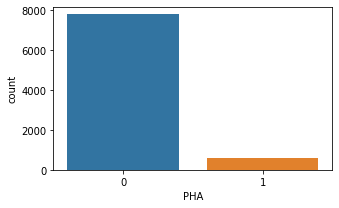

In [ ]:
# Balance check for labels
print(Counter(df.PHA))

plt.figure(figsize=(5,3))
sn.countplot(x = 'PHA', data=df);

In [ ]:
# Class distribution
dist = df.PHA.value_counts(ascending = True)
target = pd.Series(dist) 
target.index=['close-call', 'not close']
target

close-call     616
not close     7799
Name: PHA, dtype: int64

## Set X and Y values

In [ ]:
# Train-test-split
cols = ['v_rel', 'v_inf', 'diameter', 'diameter_sigma', 'ordinal_dates','t_sigma_f_min'] # without dist, dist_min, dist_max,  h which would cause data leakage
X, y = df[cols], df.PHA
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=random_seed)

# #Scaling for Models
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

## Undersampling of the majority class (PHA = 0)

In [ ]:
ros = under_sampling.RandomUnderSampler(random_state=random_seed)
X_resampled, y_resampled = ros.fit_resample(X, y)

Counter({0: 616, 1: 616})


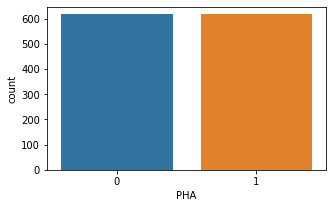

In [ ]:
print(Counter(y_resampled))

plt.figure(figsize=(5,3))
sn.countplot(x = y_resampled);

In [ ]:
# Test/Train/Split and scaling of the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, train_size = 0.8, random_state=random_seed)

#Scaling for Models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Oversampling of the minority class (PHA = 1)

In [ ]:
# ros = over_sampling.RandomOverSampler(random_state=random_seed)
# X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
# print(Counter(y_resampled))

# plt.figure(figsize=(5,3))
# sn.countplot(x = y_resampled);

In [ ]:
# # Test/Train/Split and scaling of the resampled data

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, train_size = 0.8, random_state=random_seed)

# #Scaling for Models
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

## Supervised Learning

### KNN Classifier

In [ ]:
#Train a KNN Classifier -- we should play around with hyperparameter tuning
knn = KNeighborsClassifier(n_neighbors = 2).fit(X_train_scaled, y_train)

In [ ]:
#Prediction and evaluation on Test Set
preds = knn.predict(X_test_scaled)
print(knn.score(X_test_scaled, y_test))

0.562753036437247


In [ ]:
# Confusion Matrix and Classification Report KNN Classifier
print(confusion_matrix(y_test, preds))
print('---------------------------------------------------------------------')
print(classification_report(y_test, preds))
print(accuracy_score(y_test, preds))

[[91 38]
 [70 48]]
---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       129
           1       0.56      0.41      0.47       118

    accuracy                           0.56       247
   macro avg       0.56      0.56      0.55       247
weighted avg       0.56      0.56      0.55       247

0.562753036437247


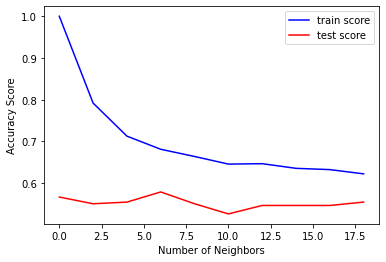

In [ ]:
# Plotting code copied over from SIADS 542 Week 1 Assignment
k_best = None
best = -np.inf

tr_scores = []
tst_scores = []
for i in np.arange(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    
    score = knn.score(X_train_scaled, y_train)
    tr_scores.append(score)
    tst_scores.append(knn.score(X_test_scaled, y_test))

    if score > best:
        best = score
        k_best = (int(i), score, knn.score(X_test_scaled, y_test))

plt.plot(np.arange(0, 19, 2), tr_scores, label='train score', color='blue')
plt.plot(np.arange(0, 19, 2), tst_scores, label='test score',color='red')
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()


### Polynomial Regressor

In [ ]:
#Testing out a polynomial regressor with the data. 

degs = np.arange(1, 6)

def polynomial_regressor():
    r2_train, r2_test = [], []
    
    for deg in degs:
        poly = PolynomialFeatures(degree=deg)
        
        X_poly = poly.fit_transform(X_train_scaled)
        linreg = LinearRegression().fit(X_poly, y_train)
        pred = linreg.predict(X_poly)
        r2_train.append(r2_score(y_train, pred))
        
        X_test_poly = poly.transform(X_test_scaled)
        pred2 = linreg.predict(X_test_poly)
        r2_test.append(r2_score(y_test, pred2))
    
    return r2_train, r2_test

polynomial_regressor()

([0.024456391281694745,
  0.26413511263102285,
  0.5620399592048693,
  0.8022416649803754,
  0.8701596132556931],
 [0.028431785907177876,
  0.10061982494030741,
  -2.9452872778978225,
  -494144.61228655645,
  -885810095415.7494])

### Random Forest

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state = random_seed).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print(rf.score(X_test_scaled, y_test))

0.6842105263157895


In [ ]:
# Confusion Matrix and Classification Report Random Forest
print(confusion_matrix(y_test, y_pred_rf))
print('---------------------------------------------------------------------')
print(classification_report(y_test, y_pred_rf))
print(accuracy_score(y_test, y_pred_rf))

[[80 49]
 [29 89]]
---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       129
           1       0.64      0.75      0.70       118

    accuracy                           0.68       247
   macro avg       0.69      0.69      0.68       247
weighted avg       0.69      0.68      0.68       247

0.6842105263157895


### Support Vector Classifier

In [ ]:
# support vector classifier

svc = SVC(kernel="rbf",random_state=random_seed).fit(X_train_scaled, y_train)
score = svc.score(X_test_scaled, y_test)
y_pred_svc = svc.predict(X_test_scaled)
print(score)


0.5789473684210527


In [ ]:
# Confusion Matrix and Classification Report support vector classifier
print(confusion_matrix(y_test, y_pred_svc))
print('---------------------------------------------------------------------')
print(classification_report(y_test, y_pred_svc))
print(accuracy_score(y_test, y_pred_svc))

[[57 72]
 [32 86]]
---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.44      0.52       129
           1       0.54      0.73      0.62       118

    accuracy                           0.58       247
   macro avg       0.59      0.59      0.57       247
weighted avg       0.59      0.58      0.57       247

0.5789473684210527


### Logistic Regression

In [ ]:
# logistic regression model

lr = LogisticRegression(random_state=random_seed).fit(X_train_scaled, y_train)
score = lr.score(X_test_scaled, y_test)
y_pred_lr = lr.predict(X_test_scaled)
print(score)



0.4898785425101215


In [ ]:
# Confusion Matrix and Classification Report logistic regression model
print(confusion_matrix(y_test, y_pred_lr))
print('---------------------------------------------------------------------')
print(classification_report(y_test, y_pred_lr))
print(accuracy_score(y_test, y_pred_lr))

[[52 77]
 [49 69]]
---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.40      0.45       129
           1       0.47      0.58      0.52       118

    accuracy                           0.49       247
   macro avg       0.49      0.49      0.49       247
weighted avg       0.49      0.49      0.49       247

0.4898785425101215


### Deep Learning Model Using TensorFlow

In [ ]:
#Playing around with a TensorFlow model
tf.random.set_seed(random_seed)
model = Sequential([
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(
    loss= 'binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
history = model.fit(X_train_scaled, y_train, epochs=50)
model.summary()

Epoch 1/50
31/31 [==============================] - 2s 5ms/step - loss: 0.6945 - accuracy: 0.5117 - precision: 0.5155 - recall: 0.5683
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5452 - precision: 0.5506 - recall: 0.5462
Epoch 3/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5563 - precision: 0.5558 - recall: 0.6104
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6774 - accuracy: 0.5604 - precision: 0.5644 - recall: 0.5723
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6756 - accuracy: 0.5756 - precision: 0.5893 - recall: 0.5301
Epoch 6/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5736 - precision: 0.5707 - recall: 0.6325
Epoch 7/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6695 - accuracy: 0.5939 - precision: 0.5881 - recall: 0.6566
Epoch 8/50
31/31 [==============================] - 0s 

In [ ]:
# tensorflow evaluation on scaled test data
result = model.evaluate(X_test_scaled, y_test)
dict(zip(model.metrics_names, result))

8/8 [==============================] - 0s 7ms/step - loss: 0.7340 - accuracy: 0.5911 - precision: 0.5691 - recall: 0.5932


{'accuracy': 0.591093122959137,
 'loss': 0.7339567542076111,
 'precision': 0.5691056847572327,
 'recall': 0.5932203531265259}

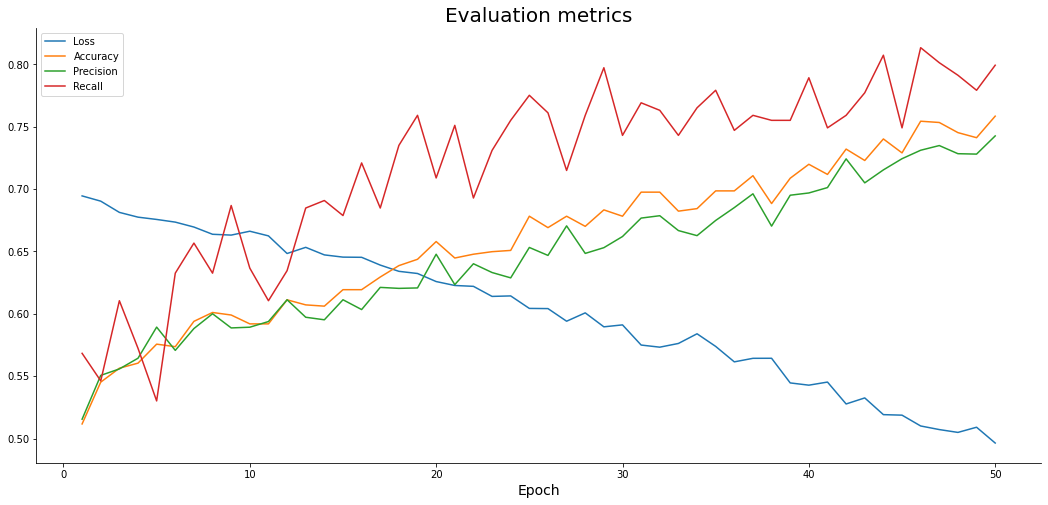

In [ ]:
# Plotting params from above TF model
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.plot(
    np.arange(1, 51), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, 51), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, 51), 
    history.history['precision'], label='Precision'
)
plt.plot(
    np.arange(1, 51), 
    history.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

## Deep Learning Model Using PyTorch

In [ ]:
# class for preparing the dataset in batch format

class SmallBodyDataset(Dataset):
  def __init__(self, dataset):
    super().__init__()
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled.to_numpy(), y_resampled.to_numpy(), test_size = 0.2, train_size = 0.8, random_state=random_seed) # using the resampled data

    #Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if dataset == 'train':
      self.dataset = torch.from_numpy(X_train_scaled).float()
      self.labels = torch.from_numpy(y_train).float()
    elif dataset == 'test':
      self.dataset = torch.from_numpy(X_test_scaled).float()
      self.labels = torch.from_numpy(y_test).float()
    else:
      raise ValueError('Unknown dataset!')

  def __getitem__(self, index):
    return self.dataset[index], self.labels[index] # return row as tuple (features, label)
    
  def __len__(self):
    return len(self.dataset)  # return length of the dataset

In [ ]:
# define dataloader with batchsize for the training and test data

batchSize_train = 32
batchSize_test = 1

dataloaders = {
    "train": DataLoader(SmallBodyDataset("train"), batch_size = batchSize_train, shuffle = True),
    "test": DataLoader(SmallBodyDataset("test"), batch_size = batchSize_test, shuffle = False)
}

# define train and test loader
train_loader  = dataloaders['train']
test_loader  = dataloaders['test']

In [ ]:
# hyperparameters
EPOCHS = 50
LEARNING_RATE = 0.001

In [ ]:
class BinaryClassification(nn.Module):
  def __init__(self):
    super(BinaryClassification, self).__init__()
    # Number of input features is 6.
    self.layer_1 = nn.Linear(6, 128) 
    self.layer_2 = nn.Linear(128, 256)
    self.layer_3 = nn.Linear(256, 256)
    self.layer_out = nn.Linear(256, 1) 
    
    self.relu = nn.ReLU()
    # self.dropout = nn.Dropout(p=0.1)
    # self.batchnorm1 = nn.BatchNorm1d(128)
    # self.batchnorm2 = nn.BatchNorm1d(256)
      
  def forward(self, inputs):
    x = self.relu(self.layer_1(inputs))
    # x = self.batchnorm1(x)
    x = self.relu(self.layer_2(x))
    # x = self.batchnorm2(x)
    # x = self.dropout(x)
    x = self.relu(self.layer_3(x))
    x = self.layer_out(x)
      
    return x

In [ ]:
# check if our GPU is active
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# initialize model, define loss criteria and optimizer
torch.manual_seed(random_seed)
model = BinaryClassification()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# function for calculating the accuracy

def binary_acc(y_pred, y_test):
  y_pred_tag = torch.round(torch.sigmoid(y_pred))

  correct_results_sum = (y_pred_tag == y_test).sum().float()
  acc = correct_results_sum/y_test.shape[0]
  acc = torch.round(acc * 100)
  
  return acc

In [ ]:
# training the model using train_loader 
torch.manual_seed(random_seed)

model.train()
for e in range(1, EPOCHS+1):
  epoch_loss = 0
  epoch_acc = 0
  for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    
    y_pred = model(X_batch)
    
    loss = criterion(y_pred, y_batch.unsqueeze(1))
    acc = binary_acc(y_pred, y_batch.unsqueeze(1))
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += acc.item()
      

  print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.69756 | Acc: 51.613
Epoch 002: | Loss: 0.68562 | Acc: 53.871
Epoch 003: | Loss: 0.68555 | Acc: 54.548
Epoch 004: | Loss: 0.68348 | Acc: 55.419
Epoch 005: | Loss: 0.68241 | Acc: 55.742
Epoch 006: | Loss: 0.68079 | Acc: 55.968
Epoch 007: | Loss: 0.67714 | Acc: 56.871
Epoch 008: | Loss: 0.67819 | Acc: 56.677
Epoch 009: | Loss: 0.67461 | Acc: 57.194
Epoch 010: | Loss: 0.67275 | Acc: 57.871
Epoch 011: | Loss: 0.66939 | Acc: 57.742
Epoch 012: | Loss: 0.66087 | Acc: 58.806
Epoch 013: | Loss: 0.65873 | Acc: 61.000
Epoch 014: | Loss: 0.64610 | Acc: 62.968
Epoch 015: | Loss: 0.64939 | Acc: 61.871
Epoch 016: | Loss: 0.64027 | Acc: 63.129
Epoch 017: | Loss: 0.63701 | Acc: 62.516
Epoch 018: | Loss: 0.63436 | Acc: 64.290
Epoch 019: | Loss: 0.63025 | Acc: 65.613
Epoch 020: | Loss: 0.61568 | Acc: 65.387
Epoch 021: | Loss: 0.63790 | Acc: 63.226
Epoch 022: | Loss: 0.61009 | Acc: 65.742
Epoch 023: | Loss: 0.61752 | Acc: 65.000
Epoch 024: | Loss: 0.60375 | Acc: 65.645
Epoch 025: | Los

In [ ]:
# Test the model using test_loader 

y_pred_list = []
y_pred_prob_list = []
y_test = []

model.eval()
with torch.no_grad(): # no backpropagation to save memory
  for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device) # move the batch to the GPU from the CPU
    y_test_pred = model(X_batch)
    y_test_pred = torch.sigmoid(y_test_pred) # make the prediction between 0 and 1
    y_pred_tag = torch.round(y_test_pred) # round off the probabilities to 0 or 1
    y_pred_list.append(y_pred_tag.cpu().numpy()) # convert the tensor to a numpy object and append it to y_pred_list
    y_pred_prob_list.append(y_test_pred.cpu().numpy()) # append probabilites to y_pred_prob_list (also convert the tensor to a numpy object)
    y_test.append(y_batch.cpu().numpy()) # also convert y_batch to a numpy object and append it to y_test

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_prob_list = [a.squeeze().tolist() for a in y_pred_prob_list]
y_test = [a.squeeze().tolist() for a in y_test]

In [ ]:
# Confusion Matrix and Classification Report for the PyTorch model

print(confusion_matrix(y_test, y_pred_list))
print('---------------------------------------------------------------------')
print(classification_report(y_test, y_pred_list))
print(accuracy_score(y_test, y_pred_list))

[[75 54]
 [40 78]]
---------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.65      0.58      0.61       129
         1.0       0.59      0.66      0.62       118

    accuracy                           0.62       247
   macro avg       0.62      0.62      0.62       247
weighted avg       0.62      0.62      0.62       247

0.6194331983805668


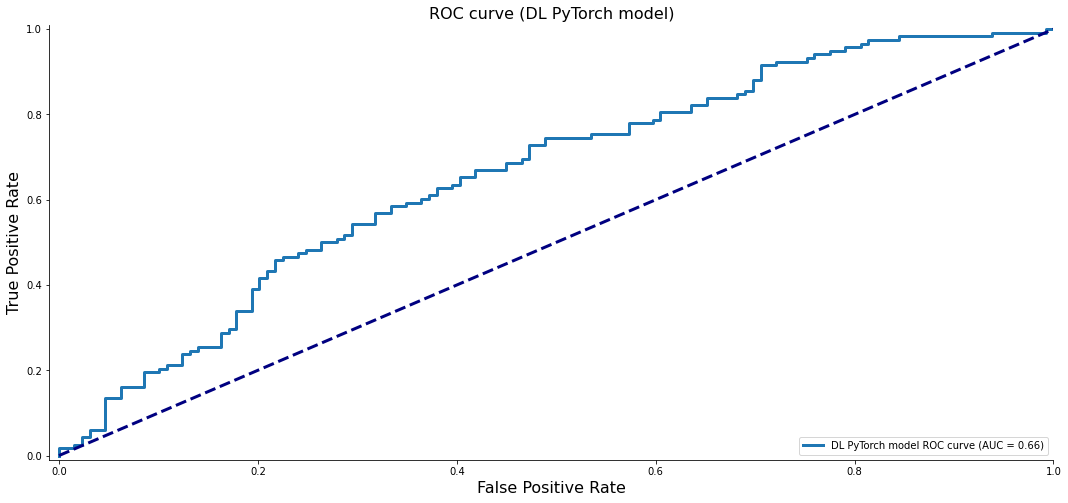

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_list)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='DL PyTorch model ROC curve (AUC = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (DL PyTorch model)', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

### Dummy Classifier

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)
print(dummy_clf.score(X_test_scaled, y_test))

0.4777327935222672


In [ ]:
# Confusion Matrix and Classification Report for the Dummy Classifier

print(confusion_matrix(y_test, dummy_clf.predict(X_test_scaled)))
print('---------------------------------------------------------------------')
print(classification_report(y_test, dummy_clf.predict(X_test_scaled)))

[[  0 129]
 [  0 118]]
---------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       129
         1.0       0.48      1.00      0.65       118

    accuracy                           0.48       247
   macro avg       0.24      0.50      0.32       247
weighted avg       0.23      0.48      0.31       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Unsupervised Learning

## PCA Transformation on Original Variables

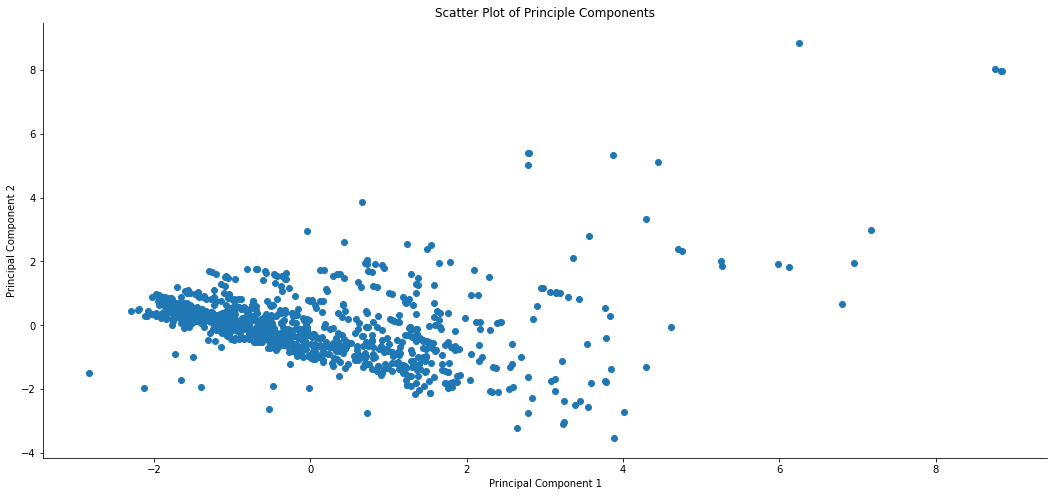

In [ ]:
# PCA
pca = PCA(random_state = random_seed, n_components = 2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
X_train_pca = pipe.fit_transform(X_train)
plot = plt.scatter(X_train_pca[:,0], X_train_pca[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Principle Components')
plt.show()

In [ ]:
# biplot for PCA from 543

def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    zoom = 1
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    width = 2.0 * zoom
    scalex = width/(xs.max()- xs.min())
    scaley = width/(ys.max()- ys.min())
    text_scale_factor = 1.3
        
    fig = plt.gcf()
    fig.set_size_inches(9, 9)
    
    plt.scatter(xs*scalex, ys*scaley, s=9)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],
                  color='b',alpha=0.9, head_width = 0.03 * zoom) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     labels[i], color='g', ha='center', va='center')
    
    plt.xlim(-zoom,zoom)
    plt.ylim(-zoom,zoom)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

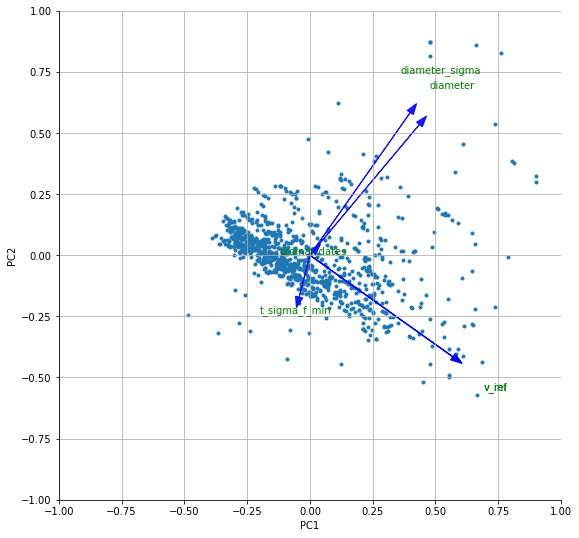

In [ ]:
biplot(X_train_pca, np.transpose(pca.components_[0:, :]), 
       pca.n_features_, 1, 2, labels=X.columns)

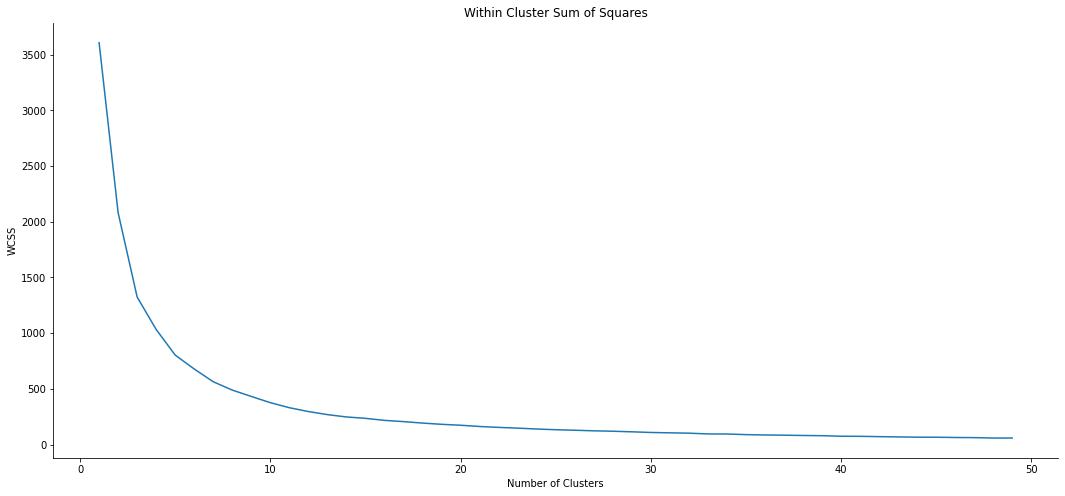

In [ ]:
# find to optimal clusters
wcss = []
r = range(1, 50)
for k in r:
    km = KMeans(n_clusters = k, init='k-means++', max_iter=300, n_init=10, random_state=random_seed)
    km.fit(X_train_pca)
    wcss.append(km.inertia_)

plt.plot(r, wcss)
plt.title('Within Cluster Sum of Squares')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

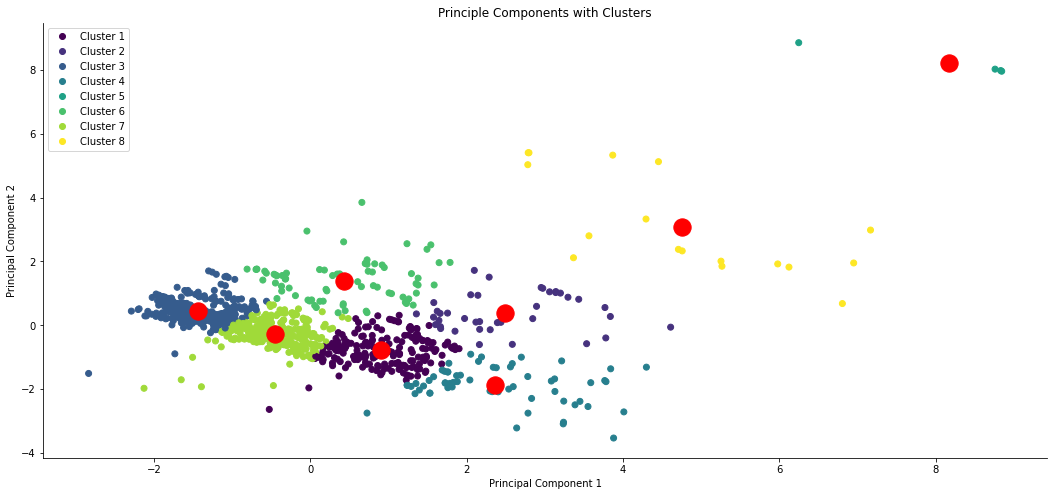

In [ ]:
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8']

km = KMeans(n_clusters = 8, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
pred_y = km.fit_predict(X_train_pca)
plot = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c = pred_y)
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=300, c='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principle Components with Clusters')
plt.legend(handles=plot.legend_elements()[0], labels = labels)
plt.show()

In [ ]:
km.cluster_centers_

array([[ 0.90623361, -0.78499829],
       [ 2.49390385,  0.38807439],
       [-1.43876017,  0.45030052],
       [ 2.36199824, -1.87624129],
       [ 8.16922322,  8.20077822],
       [ 0.43293624,  1.39655475],
       [-0.44840096, -0.26608516],
       [ 4.7596397 ,  3.08592804]])

In [ ]:
silhouette_score(X_train_pca, km.labels_)

0.41414335828387594